### Amazon Fine Food Reviews

Download link: https://snap.stanford.edu/data/web-FineFoods.html

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories.

**Dataset Statistics**
- Number of reviews: 568,454
- Number of users: 256,059
- Number of products: 74,258
- Users with > 50 reviews: 260
- Median no. of words per review: 56
- Timespan: Oct 1999-Oct 2012

Problem : `Word embedding`

A `word embedding` is a learned representation for text where words that have the same meaning have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems.

we use a dataset of `Amazon food reviews` to examine the behaviour of two metrics of similarity in vocabulary: 

* `Jaccard similarity` (Danescu-Niculescu-Mizil et al. 2013) and 
* `cosine similarity` on word embeddings. 

The dataset is available at the Stanford Network Analysis Project (SNAP). It has `568,454` reviews of `74,258` fine food products posted on `Amazon` between October 1999 and October 2012. Its format is plain text with eight lines per review, as illustrated here:

* product/productId:   B001E4KFG0 
* review/userId: A3SGXH7AUHU8GW 
* review/profileName: delmartian 
* review/helpfulness: 1/1 
* review/score: 5.0
* review/time: 1303862400 
* review/summary: Good Quality Dog Food
* review/text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.


where

* product/productId: asin, e.g. amazon.com/dp/B001E4KFG0
* review/userId: id of the user, e.g. A3SGXH7AUHU8GW
* review/profileName: name of the user
* review/helpfulness: fraction of users who found the review helpful
* review/score: rating of the product
* review/time: time of the review (unix time)
* review/summary: review summary
* review/text: text of the review

In addition to the cleaned dataset of reviews, the problem uses the following files:
* A CSV containing the IDs of 2,000 reviews that we have identified as being about the following types of products: 
 - coffee, 
 - tea, 
 - chocolate, and 
 - pet food. 
 
 These lists have reasonably high precision, but they do not have good recall; there are actually many more reviews about some of these types of product. We have chosen 2,000 reviews to equalize the counts across categories and reduce the computational load.


* A list of English stopwords (frequent words that are deemed to be uninformative in any kind of topic analysis). You should use scikit-learn’s default list which is derived from a list provided by the Information Retrieval group at the University of Glasgow. To access this list, import the stop_words module from sklearn.feature_extraction. The English stopwords can be accessed via stop_words.ENGLISH_STOP_WORDS.


* A set of word embeddings calculated on the cleaned reviews using the `fastText algorithm`. These are in a plain text file in which each line contains a word followed by a vector of 100 numbers. The first line is for the word ‘the’:


the 0.089743 0.039805 0.21799 0.18479 -0.044213 -0.04277

0.058188 0.037172 -0.18977 0.025385 -0.21922 0.114 -0.011241 -

0.13672 -0.030411 -0.15679 -0.0065133 0.1738 -0.2882 0.10161 -

0.091983 -0.086349 0.037555 -0.30686 0.076373 -0.38283 -

0.085284 0.017897 -0.041968 -0.24696 -0.095749 -0.20595 -

0.2875 -0.24801 -0.176 -0.043766 -0.099602 -0.005521 -0.034822

0.17472 0.099797 -0.23715 -0.13945 0.11303 -0.073818 0.057841

0.0039705 -0.024443 0.0033322 0.217 0.045624 -0.25768 0.02826

-0.21045 -0.17288 0.043513 0.1688 -0.13288 0.1699 0.057569 -

0.038435 0.096366 -0.22004 0.11821 0.23242 0.015993 0.037513 -

0.046368 -0.0264 -0.27571 -0.239 -0.010384 -0.06584 0.075898 -

0.09447 0.28489 0.19827 0.057513 -0.030723 0.063337 -0.08067 -

0.0062808 -0.2257 0.076093 0.26215 0.12353 -0.16808 -0.19644

0.0080869 0.031408 0.028021 0.017631 0.074064 -0.13612 -

0.16408 -0.096008 -0.021452 0.034294 0.072767 0.10976


The documentation for fastText is here: https://github.com/facebookresearch/fastText. The training was done on a file of fully normalised review text, in which `capitalisation` and `punctuation` had been removed, and each line contains the full text of a review (thus, the training has access to the break between one review and the next, but not to the sentence boundaries). The following parameter settings were used: vector length 100, the context of 5 words on either side, the minimum word count of 20, a negative sampling rate of 20. The training took three minutes on the laptop that was used for this dataset, and you should have no trouble calculating embeddings with other parameter settings if you wish to.


In [2]:
# Import necessary modules

import re
import os
import io
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import repeat
from datetime import datetime
from collections import Counter
from operator import itemgetter
from scipy.spatial.distance import cosine
from sklearn.feature_extraction import stop_words

pd.set_option('display.max_colwidth', -1)
pd.options.mode.chained_assignment = None # Silence pandas SettingWithCopyWarning
sns.set(style='whitegrid', color_codes=True)

### Part I: Dataframe and Dictionary Setup

**Step 1**: Download the food reviews from the SNAP website, unzip the file, load the dataset, clean the dataset, normalise the review text, and set up dataframes of reviews for our target product categories.

In [2]:
food_reviews_filepath = os.path.expanduser('~/Downloads/NLP_datasets/foods.txt') # Replace this with the path to the location of the file on your computer.

with open(food_reviews_filepath) as f:
    food_reviews_raw = f.read()

In [3]:
fields = ['product/productId', 'review/userId', 'review/profileName', 'review/helpfulness',
           'review/score', 'review/time', 'review/summary', 'review/text']

df = pd.DataFrame([{line.split(': ')[0]:''.join(line.split(': ')[1]) 
                    for line in review.split('\n') if line.split(': ')[0] in fields}
                    for review in list(filter(None, food_reviews_raw.split('\n\n')))]) # Remove empty string created by the split.

df.columns = ['product_id', 'helpfulness', 'profile_name', 'score', 'summary', 'text', 'time', 'user_id']

# change to reordered columns
reordered_columns = ['product_id', 'user_id', 'profile_name', 'helpfulness', 'score', 'time', 'summary', 'text']
df = df[reordered_columns]

In [4]:
# normalize the dataset by removing quotations, ampersand, punctuations and capital letters, etc.

df['norm_text'] = df.text.map(lambda x: re.sub(r'<a href=\S+>', '', x))
df['norm_text'] = df.norm_text.map(lambda x: x.replace('</a>', '')) 
df['norm_text'] = df.norm_text.map(lambda x: x.replace('<br />', ' ')) 
df['norm_text'] = df.norm_text.map(lambda x: x.replace('&quot;', '')) 
df['norm_text'] = df.norm_text.map(lambda x: x.replace('&amp;', 'and'))
df['norm_text'] = df.norm_text.map(lambda x: x.lower()) 
df['norm_text'] = df.norm_text.map(lambda x: x.translate(str.maketrans('', '', string.punctuation))) 
df['norm_text'] = df.norm_text.map(lambda x: x.replace('  ', ' '))

In [5]:
df = df.drop_duplicates(subset=['text'], keep=False) # remove duplicates

In [6]:
df.info()  # info about the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334656 entries, 0 to 568453
Data columns (total 9 columns):
product_id      334656 non-null object
user_id         334656 non-null object
profile_name    334656 non-null object
helpfulness     334656 non-null object
score           334656 non-null object
time            334656 non-null object
summary         334656 non-null object
text            334656 non-null object
norm_text       334656 non-null object
dtypes: object(9)
memory usage: 25.5+ MB


**Reviews from Target Product Categories**

Load 2000 reviews of coffee, tea, chocolate, and pet food.

In [7]:
# read the target product data
product_indexes_df = pd.read_csv('product_indexes.csv', index_col=0)

In [8]:
coffee_df = df[df.index.isin(product_indexes_df.coffee)]  # Return a boolean array where the index values are in values.
tea_df = df[df.index.isin(product_indexes_df.tea)]
chocolate_df = df[df.index.isin(product_indexes_df.chocolate)]
petfood_df = df[df.index.isin(product_indexes_df.petfood)]

In [9]:
print(len(coffee_df), len(tea_df), len(chocolate_df), len(petfood_df))

2000 2000 2000 2000


**Step 2**: Create another dataframe containing a random sample of 2,000 RANDOM-REVIEWS from the full dataset. Note that the RANDOM-REVIEWS is likely to include some number of coffee, tea, chocolate, and pet food reviews.

In [11]:
random_df = df.sample(2000)
random_df.head()

,product_id,user_id,profile_name,helpfulness,score,time,summary,text,norm_text
275042,B0015D443A,A1C1B897ADP239,A. Crossland,0/0,1.0,1226188800,If I could give it zero stars I would...,"I was really excited about trying these as I am a big fan of the other raspberry candies and they are very hard to come by. However, I was quickly disappointed after the first taste. There is very little flavor and a definite soapy aftertaste. Just awful!",i was really excited about trying these as i am a big fan of the other raspberry candies and they are very hard to come by however i was quickly disappointed after the first taste there is very little flavor and a definite soapy aftertaste just awful
118269,B007RTR89S,A3AL9NFNWTRV39,booklover1335 for &#34;Seductive Musings&#34;,0/0,5.0,1337817600,Two Thumps Up! (Way up),"Shampoos are tricky for my hair. It's a bit more coarse, and has a bit of a curl to it, but after using this shampoo for a short time I've found that my hair has more shine and is easier to style than with my previous shampoo which I paid more for.<br /><br />I do color my hair, but I can't really comment on how well it protects against fading since my color was a bit faded prior to using this shampoo, but if the product lives up to this claim like it does the others than I am sure it will do an admiral job.<br /><br />For the price I LOVE this shampoo. I love the way it smells (not to fruity or flowery, just a nice scent) I love that my scalp is less irritated, and I like my hair more while using it (something that is hard to do). My only wish was that it was sulfate free, but at this price I think I will be switching to this shampoo from now on!",shampoos are tricky for my hair its a bit more coarse and has a bit of a curl to it but after using this shampoo for a short time ive found that my hair has more shine and is easier to style than with my previous shampoo which i paid more for i do color my hair but i cant really comment on how well it protects against fading since my color was a bit faded prior to using this shampoo but if the product lives up to this claim like it does the others than i am sure it will do an admiral job for the price i love this shampoo i love the way it smells not to fruity or flowery just a nice scent i love that my scalp is less irritated and i like my hair more while using it something that is hard to do my only wish was that it was sulfate free but at this price i think i will be switching to this shampoo from now on
282540,B0055BIFJM,A6AY2M778I3O1,"J. Todd ""sandnsea""",0/0,1.0,1341964800,Ick,"I'm not fussy about sugar-free foods because, after all, they're sugar-free. But these cookies are . I've had the sugar-free wafer cookies, they're okay. I've had some sugar-free chocolates from Hershey & Russell Stover, they're good. So I was expecting something that would satisfy a craving, at the least. These are dry and flavorless. I'd rather eat a saltine cracker.",im not fussy about sugarfree foods because after all theyre sugarfree but these cookies are ive had the sugarfree wafer cookies theyre okay ive had some sugarfree chocolates from hershey russell stover theyre good so i was expecting something that would satisfy a craving at the least these are dry and flavorless id rather eat a saltine cracker
213625,B001VNGOGY,A2NAZ6EX7YIA7N,G0NZ0,2/2,5.0,1326240000,Awesome delicate flavor,"I used Frontier Peppermint for months and then I decided to get the Spearmint too. Both are absolutely fantastic. The spearmint is fairly sweet and mild, the peppermint stronger and you feel it in your throat.<br />I use both iced.<br />They are also excellent when mixed together.<br />Excellent deal anyway, the bag is huge and the product really really fresh.",i used frontier peppermint for months and then i decided to get the spearmint too both are absolutely fantastic the spearmint is fairly sweet and mild the peppermint stronger and you feel it in your throat i use both iced they are also excellent when mixed to

**Step 3**: Referring if necessary to the answer key for the second formative, create a dictionary of the vocabulary of the whole dataset, as well as dictionaries of vocabularies of the COFFEE-REVIEWS, TEA-REVIEWS, CHOCOLATE-REVIEWS, PETFOOD-REVIEWS, and RANDOM-REVIEWS. Please use the normalised review text, not the original text (the ‘norm_text’ column in the dataframe as opposed to the ‘text’ column). The keys of each dictionary should be the vocabulary items, and the corresponding values should be their frequencies. Remove all words on the stopword list from all of the dictionaries. Now your dictionaries contain only words that may be relevant to the semantic relationships amongst the topics.

In [76]:
print('Number of words in stopwords list:', len(stop_words.ENGLISH_STOP_WORDS))
print('50 words on the stopwords list:', list(stop_words.ENGLISH_STOP_WORDS)[:50])

Number of words in stopwords list: 318
50 words on the stopwords list: ['nowhere', 'and', 'eight', 'eg', 'they', 'throughout', 'nobody', 'indeed', 'always', 'ie', 'something', 'due', 'further', 'neither', 'ten', 'that', 'above', 'thin', 'mill', 'were', 'yet', 'hasnt', 'her', 'besides', 'least', 'name', 'everything', 'them', 'after', 'else', 'could', 'go', 'another', 'herself', 'couldnt', 'very', 'via', 'nine', 'myself', 'therefore', 'anything', 'nor', 'namely', 'elsewhere', 'has', 'ours', 'somewhere', 'will', 'except', 'five']


In [63]:
def create_dict(norm_text):
    wordlist = [review.split(' ') for review in norm_text] # Create a list of lists (words in each review).
    wordlist = [word for review in wordlist for word in review] # Flatten the wordlist to create one list of all words in the reviews.
    vocab_dict = Counter(wordlist) # Create a Counter object (a dictionary of words and their frequencies).
    for word in list(vocab_dict):
        if word in stop_words.ENGLISH_STOP_WORDS or word=='':
            del vocab_dict[word]
    return vocab_dict

In [64]:
all_dict = create_dict(df.norm_text)  # Using the normalised review text
coffee_dict = create_dict(coffee_df.norm_text)
tea_dict = create_dict(tea_df.norm_text)
chocolate_dict = create_dict(chocolate_df.norm_text)
petfood_dict = create_dict(petfood_df.norm_text)
random_dict = create_dict(random_df.norm_text)

In [66]:
print('Number of unique words in all reviews:', len(all_dict))
print('Number of unique words in coffee reviews:', len(coffee_dict))
print('Number of unique words in tea reviews:', len(tea_dict))
print('Number of unique words in chocolate reviews:', len(chocolate_dict))
print('Number of unique words in pet food reviews:', len(petfood_dict))
print('Number of unique words in random reviews:', len(random_dict))
print('')
print('Most common words in all reviews:', all_dict.most_common(10))
print('Most common words in coffee reviews:', coffee_dict.most_common(10))
print('Most common words in tea reviews:', tea_dict.most_common(10))
print('Most common words in chocolate reviews:', chocolate_dict.most_common(10))
print('Most common words in pet food reviews:', petfood_dict.most_common(10))
print('Most common words in random reviews:', random_dict.most_common(10))

Number of unique words in all reviews: 184586
Number of unique words in coffee reviews: 7033
Number of unique words in tea reviews: 8271
Number of unique words in chocolate reviews: 8567
Number of unique words in pet food reviews: 10807
Number of unique words in random reviews: 9901

Most common words in all reviews: [('like', 136853), ('good', 112042), ('taste', 96321), ('just', 95043), ('great', 93710), ('product', 89240), ('flavor', 79472), ('tea', 76165), ('coffee', 71227), ('love', 67937)]
Most common words in coffee reviews: [('coffee', 4460), ('like', 826), ('good', 751), ('taste', 613), ('flavor', 592), ('great', 553), ('cup', 528), ('just', 491), ('price', 430), ('love', 409)]
Most common words in tea reviews: [('tea', 5985), ('like', 876), ('flavor', 721), ('teas', 705), ('taste', 681), ('good', 680), ('green', 674), ('great', 591), ('just', 567), ('drink', 534)]
Most common words in chocolate reviews: [('chocolate', 3948), ('like', 970), ('dark', 784), ('good', 746), ('taste

We can already see from the most common words that coffee is more similar to tea, chocolate, and random products than it is to pet food. 'Taste' and 'flavor' are common words in the coffee, tea, chocolate, and random reviews, but are not as common in the pet food reviews. This makes sense - the writers of the pet food reviews cannot directly comment on the taste of pet food! This also indicates that most of the products in the dataset are edible by humans.

Moreover, the most common words provide us with a sense of the basic sentiment of the reviews - many seem to be positive ('like', 'love', 'good', and 'great' are extremely common words).

There are noticeably more unique lexical items in the pet food reviews than the reviews of our other product categories of interest. This suggests that the pet food reviews are longer. To corroborate this, we can check the average length of reviews in each product category. We can also print the full text of random reviews from each category.

In [142]:
def mean_length(norm_text):
    review_lengths = []
    for review in norm_text:
        review_lengths.append(len(review.split(' ')))
    return sum(review_lengths)/len(review_lengths)

In [146]:
print('Average length of review:', mean_length(df.norm_text))
print('Average length of coffee review:', mean_length(coffee_df.norm_text))
print('Average length of tea review:', mean_length(tea_df.norm_text))
print('Average length of chocolate review:', mean_length(chocolate_df.norm_text))
print('Average length of pet food review:', mean_length(petfood_df.norm_text))

Average length of review: 74.1101907630522
Average length of coffee review: 66.092
Average length of tea review: 78.5345
Average length of chocolate review: 76.2385
Average length of pet food review: 129.7015


In [137]:
coffee_df.sample(1)['text']

406091    Coffee arrived damaged.  Damage was from one pound of coffeelosing the vacuum packaging.  This damage occurred from handling at the warehouse where three pounds of coffee was grouped for sale.  Dispute the damage the coffee tasted ok.
Name: text, dtype: object

In [138]:
tea_df.sample(1)['text']

510459    I LOVE INEEKA PEPPERMINT TEA!!!  It's made from peppermint leaves, not from tea leave, so the taste is soft, minty, and clean.  Excellent for upset stomach, sore throat, or just to warm up or cleanse the palette.  LOVE IT LOVE IT LOVE IT!!!
Name: text, dtype: object

In [139]:
chocolate_df.sample(1)['text']

66281    The second these got on my doorstep I brought them into the house I proceeded to open them and tasted all 3 of the flavors I started with the remy martin I bit into it and it oozed a goo (I was expecting liquid) I mostly tasted the chocolate nothing else I moved onto the orange vodka I bit into this and WOW it tasted strongly of oranges (well duh) finally moving onto the cointerui I bit into it and while it didnt have much flavor it burned (just like real vodka) which suprised me because its only 0.5% alcohol ... I should also note these DO have alcohol in them so dont go giving these away on haloween XDDD anyways kool chocolates these will be a hit on new years I will order again
Name: text, dtype: object

In [136]:
petfood_df.sample(1)['text']

101244    We have a 9 year old 120 lb. Mastiff/Sheepdog mix that has had ear infections her entire life. She has been to 3 different vets to remedy the problem, and nothing helped. I had to clean her ears and use a cortizone remedy for yeast a least 3 times a week or her ears became enflamed and were painful. I heard about the Blue dog food, and I liked the ingredients used. So we decided to try it. I couldn't believe that within 2 weeks, her ears were no longer squishy with fluid inside, and the smell went away. We have been using both the dry and the canned Blue formulas and after 2 months there has been no recurrence of infection or inflammation. In the 9 years we have had her, we have tried at least 4 other brands of dog food including some of the high end expensive ones. It had never dawned on us that her food might be causing the infections in her ears. Thanks to Blue dog food, our girl will not have to endure the pain of ear infections the rest of her life.
Name: text, dtype: ob

### Part II: Comparison of Similarity Metrics

**Jaccard similarity**. The Jaccard similarity of two sets is the size of the intersection of the sets divided by the size of the union. Here, the relevant sets are the dictionaries for the various review sets.

**Step 1**: Compute the Jaccard similarity of coffee to tea, chocolate, pet food, and random products by taking the intersections and unions of the dictionaries that you have set up (more specifically, the intersections and unions of their keys).

In [101]:
A = {1, 2, 3}
B = {2, 3, 4}
print(A.intersection(B), A.union(B))

{2, 3} {1, 2, 3, 4}


In [103]:
def jaccard_similarity(dict1, dict2):
    intersection = len(set(dict1).intersection(set(dict2)))
    union = len(set(dict1).union(set(dict2)))
    return intersection/union

In [122]:
jaccard_similarities = []
jaccard_similarities.append(('coffee:coffee', jaccard_similarity(coffee_dict, coffee_dict)))
jaccard_similarities.append(('coffee:tea', jaccard_similarity(coffee_dict, tea_dict)))
jaccard_similarities.append(('coffee:chocolate', jaccard_similarity(coffee_dict, chocolate_dict)))
jaccard_similarities.append(('coffee:petfood', jaccard_similarity(coffee_dict, petfood_dict)))
jaccard_similarities.append(('coffee:random', jaccard_similarity(coffee_dict, random_dict)))

In [124]:
jaccard_similarities

[('coffee:coffee', 1.0),
 ('coffee:tea', 0.3160202940923553),
 ('coffee:chocolate', 0.30894445376741064),
 ('coffee:petfood', 0.25386561709305594),
 ('coffee:random', 0.307745771874276)]

**QUESTION 1**: Rank the sets by their similarity to coffee (with the self-similarity of coffee to coffee obviously anchoring this scale at first place). Which product is the most similar? Which product is the least similar?

In [131]:
sorted(jaccard_similarities, key=itemgetter(1), reverse=True)

[('coffee:coffee', 1.0),
 ('coffee:tea', 0.3160202940923553),
 ('coffee:chocolate', 0.30894445376741064),
 ('coffee:random', 0.307745771874276),
 ('coffee:petfood', 0.25386561709305594)]

Tea is the most similar product to coffee, and pet food is the least similar product. Interestingly, the similarity of coffee to chocolate and random products is not far off the similarity of coffee to tea - so tea does not win by a very large margin!

**fastText similarity**. To define the overall semantics of a text, a common practice is simply to average together the word embedding vectors for all the relevant words in the text. Here, we will take the relevant words simply to be the words that survived in our dictionaries when we eliminated the stopwords. However, words that occurred less than 20 times will have to be disregarded because we couldn’t compute embeddings for them. The standard measure of similarity for two word embedding vectors is the cosine of the angle between them (this ignores the norm of the vector, something that is used in some more advanced methods). Recall that cos(0) = 1.0 (e.g., if the vectors point exactly in the same direction, the cosine of the angle between them is 1.0) and cos(1) = 0.0 (e.g., if the vectors are orthogonal, the cosine value is 0.0).

**Step 2**: By looping over all reviews in each of the review categories, and then looping over all
the words in each review, determine an embedding for COFFEE-REVIEWS, TEA-REVIEWS, CHOCOLATE-REVIEWS, PETFOOD-REVIEWS and RANDOM-REVIEWS. That is, treat the set of reviews on a topic as if it was just one long review, with the individual reviewers concatenated into one long text. Using these aggregate vectors, compute the cosine similarity of coffee to tea, chocolate, pet food, and random products, and rank these similarities.

In [219]:
# This function is taken and slightly modified from https://fasttext.cc/docs/en/english-vectors.html.

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data 

In [232]:
fastText_filepath = os.path.expanduser('~/Downloads/NLP_datasets/embeddings_fasttext.vec')
vectors = load_vectors(fastText_filepath)

In [239]:
print(len(vectors['the']))
vectors['the']

100


array([ 0.089743 ,  0.039805 ,  0.21799  ,  0.18479  , -0.044213 ,
       -0.04277  ,  0.058188 ,  0.037172 , -0.18977  ,  0.025385 ,
       -0.21922  ,  0.114    , -0.011241 , -0.13672  , -0.030411 ,
       -0.15679  , -0.0065133,  0.1738   , -0.2882   ,  0.10161  ,
       -0.091983 , -0.086349 ,  0.037555 , -0.30686  ,  0.076373 ,
       -0.38283  , -0.085284 ,  0.017897 , -0.041968 , -0.24696  ,
       -0.095749 , -0.20595  , -0.2875   , -0.24801  , -0.176    ,
       -0.043766 , -0.099602 , -0.005521 , -0.034822 ,  0.17472  ,
        0.099797 , -0.23715  , -0.13945  ,  0.11303  , -0.073818 ,
        0.057841 ,  0.0039705, -0.024443 ,  0.0033322,  0.217    ,
        0.045624 , -0.25768  ,  0.02826  , -0.21045  , -0.17288  ,
        0.043513 ,  0.1688   , -0.13288  ,  0.1699   ,  0.057569 ,
       -0.038435 ,  0.096366 , -0.22004  ,  0.11821  ,  0.23242  ,
        0.015993 ,  0.037513 , -0.046368 , -0.0264   , -0.27571  ,
       -0.239    , -0.010384 , -0.06584  ,  0.075898 , -0.0944

In [778]:
# Test vector functions on sample arrays.

sample_arrays1 = [np.array([1, 2, 3]), np.array([2, 3, 4]), np.array([3, 4, 5])]
sample_arrays2 = [np.array([2, 3, 4]), np.array([3, 4, 5]), np.array([4, 5, 6])]
print(np.mean(sample_arrays1, axis=0)) # We want the average of the rows (each row is an embedding).
print(np.mean(sample_arrays2, axis=0))
1 - cosine(np.mean(sample_arrays1, axis=0), np.mean(sample_arrays2, axis=0))

[2. 3. 4.]
[3. 4. 5.]


0.9979288897338914

In addition to removing the stopwords, we need to remove words with a frequency of less than 20. Before we compute the embeddings, let's see how many of these words there are (relative to the number of words in the vocabulary of all reviews). Let's also see what some of these low-frequency words are.

In [394]:
low_freq = []
for word in list(vocab_dict):
    if vocab_dict[word] < 20:
        low_freq.append(word)

print('Number of words in all reviews:', len(vocab_dict))
print('Number of words with frequencies below 20:', len(low_freq))
print('Number of words with frequencies of at least 20:', len(vocab_dict)-len(low_freq))
print('A sample of low-frequency words:', low_freq[:50])

Number of words in all reviews: 184586
Number of words with frequencies below 20: 167483
Number of words with frequencies of at least 20: 17103
A sample of low-frequency words: ['mortarandpestal', 'mustuse', 'bitterer', 'interpersonally', 'pathetically', '422', 'engel', 'cornmuffins', '35050', 'lavenderyabsolutely', 'ouchi', 'nacks', 'peppper', 'quebecs', 'muffinstasty', 'nectarlight', 'sandal', 'weekendit', '525cs', 'salus', 'advertisethey', 'substitutewith', 'healthyplease', 'limonadas', 'sugarblah', 'levity', 'oztub', 'earthclinic', 'eleviate', 'blizzardgeddon', 'pelvicabdominal', 'gfb', 'arepowdered', 'whiteprocessed', 'yuuummm', 'bonsias', '708', 'moter', '40pricey', 'magicits', 'thon', 'spriteful', 'alomst', '814', 'chutes', 'thriled', 'vynrod', 'belligerently', 'httpwwwamazoncomtandoorchefchickenmasala10ouncedpb002goyt1orefpdsimgro3', '748']


As we can see, the **vast majority** of words are low frequency! What implications does this have for the comparison of fastText similarity with Jaccard similarity?

In [379]:
def avg_embedding(norm_text):

    wordlist = [review.split(' ') for review in norm_text]
    wordlist = [word for review in wordlist for word in review]
    vocab_dict = Counter(wordlist)
    for word in list(vocab_dict):
        if word in stop_words.ENGLISH_STOP_WORDS or word=='' or vocab_dict[word] < 20:
            del vocab_dict[word]
    
    aggregate_vectors = []
    for word in list(vocab_dict):
        try:
            # Append the word embedding the number of times the word appears in the text.
            aggregate_vectors.extend(repeat(vectors[word], vocab_dict[word]))
        except:
            print(word)
            continue
    
    return np.mean(aggregate_vectors, axis=0)

In [380]:
coffee_embedding = avg_embedding(coffee_df.norm_text)
tea_embedding = avg_embedding(tea_df.norm_text)
chocolate_embedding = avg_embedding(chocolate_df.norm_text)
petfood_embedding = avg_embedding(petfood_df.norm_text)
random_embedding = avg_embedding(random_df.norm_text)

In [395]:
fastText_similarities = []
fastText_similarities.append(('coffee:coffee', 1 - cosine(coffee_embedding, coffee_embedding)))
fastText_similarities.append(('coffee:tea', 1 - cosine(coffee_embedding, tea_embedding)))
fastText_similarities.append(('coffee:chocolate', 1 - cosine(coffee_embedding, chocolate_embedding)))
fastText_similarities.append(('coffee:petfood', 1 - cosine(coffee_embedding, petfood_embedding)))
fastText_similarities.append(('coffee:random', 1 - cosine(coffee_embedding, random_embedding)))

In [397]:
sorted(fastText_similarities, key=itemgetter(1), reverse=True)

[('coffee:coffee', 1.0),
 ('coffee:tea', 0.9181660778746203),
 ('coffee:random', 0.9168127135944747),
 ('coffee:chocolate', 0.8882519542605647),
 ('coffee:petfood', 0.7400469685771335)]

**Note**: As illuminated by its library name, the cosine function from SciPy (spatial.distance.cosine) returns the cosine *distance* as opposed to cosine *similarity*, which is what we are after. We must subtract the distance from 1 to obtain the similarity. 

As the below code demonstrates, scikit-learn does provide a [cosine_similarity function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn.metrics.pairwise.cosine_similarity) that returns exactly what we want (in array form), but its execution is slightly clunkier as it requires the reshaping of NumPy arrays (passing 1D arrays as input data is deprecated in scikit-learn). SciPy, on the other hand, is built to be optimised with NumPy, which is why we suggested it for this formative.

In [680]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(coffee_embedding.reshape(1, -1), coffee_embedding.reshape(1, -1)))
print(cosine_similarity(coffee_embedding.reshape(1, -1), tea_embedding.reshape(1, -1)))
print(cosine_similarity(coffee_embedding.reshape(1, -1), random_embedding.reshape(1, -1)))
print(cosine_similarity(coffee_embedding.reshape(1, -1), chocolate_embedding.reshape(1, -1)))
print(cosine_similarity(coffee_embedding.reshape(1, -1), petfood_embedding.reshape(1, -1)))

[[1.]]
[[0.91816608]]
[[0.91681271]]
[[0.88825195]]
[[0.74004697]]


**QUESTION 2**: How does this ranking compare to the one you calculated with Jaccard similarity? Which similarity metric better captures our prediction that coffee is more similar to tea or chocolate than it is to pet food and also to a random sample?

This ranking is similar to the Jaccard similarity ranking, with the exception that random reviews are almost as similar to coffee reviews as tea reviews are. Tea reviews are more similar to coffee reviews than chocolate reviews, and pet food reviews are the least similar. 

Although the differences between coffee and tea, chocolate, and pet food reviews are more pronounced with the fastText embeddings, Jaccard similarity better captures our prediction because it is better able to distinguish between product categories and the random sample.

**QUESTION 3**: The calculation in Step 2 above did not normalise for the length of the review in any way. Thus, a 400-word review is deemed to have the same amount of information about its topic as four different 100-word reviews taken together. Based on the results in the second formative, what do you think about this assumption? Should any kind of normalisation be applied, and if so what would you propose?

Formative II illuminated the fact that more information is captured in longer text - higher F1 scores were produced for the larger buckets. As we discussed in class last week, in the 400-word review words are not independent, whereas in four 100-word reviews, they are independent (and a certain amount of repetition might thus be expected). Thus, we should normalise for the length of the review. The most straightforward way to do this would be *gating*: only considering reviews of similar length / imposing a length cutoff. 

A more sophisticated method would be to follow Pang and Lee's (2004) partitioning approach, and only extract the most informative sections from the reviews via a discourse parse. In labelling the sentiment of movie reviews, Pang and Lee only apply text categorisation techniques to the subjective portions of the document. They extract these portions by finding minimum cuts in graphs. As we saw in class in Week 4, the discourse structure of the reviews is such that the actual evaluation of the film is concentrated in some of the sentences (other sentences might use emotionally loaded words but do not reveal what movie is being revealed, or summarise the plot, which is also not very relevant for sentiment about the film). Similarly, in our dataset we can see that many people take the opportunity to share excessive information about their pets in pet food reviews; the review does not focus exclusively on the quality of the pet food (review number 32909 below is a good case in point). This does not happen as much, interestingly, with the reviews of coffee, tea, and chocolate.

In [702]:
petfood_df.sample(5)[['text']]

,text
130143,My cat had a moderate shedding problem before I started her on this cat food. She now rarely sheds & it's nice to pet her & not have any hair on my hands. Her coat is also shinier & softer & she really likes the food. People might not want to get it due to the price but I measure out the food & I have found she actually eats less than food bought in the grocery store.
32909,"I would definitely reccomend these for your dog. My dogs love their taste and think they're getting a treat when they get these. I also save money by buying the biggest size and cutting them in half.<br /><br />Here's our tale. My dog Babe is 11 yrs old. 3 years ago at her annual check-up the vet reccomended we have her teeth cleaned (this means anesthesia). We were busy so we scheduled her appointment 2 months out. The new dog foods with teeth brushing had just come out in our area so we switched her to one. When we took her in for the teeth cleaning, the vet said she didn't need it. Yeah! Then last year we took our new dog Hercules to the vet and she showed us the CET Hextra chews. Which my dog treated like the best thing he'd ever seen. So I went home and ordered some. Amazon had the best deal I could find by far. 6 months later after daily use of the chews. Babe went in for her annual again and the vet said her teeth looked like those of a 1 yr old dog. They even brought other people in the clinic in to see her teeth. They said whatever we were doing to keep it up."
89926,"The dogs really like this and I have to say it looks so much better than the old ""brown orbs"" look of most dog food. It's a little pricey, so it doesn't work for larger dogs that eat a lot. But for medium sized dogs it seems like a winner."
52071,Yes its a little cheaper online but you better be prepared to wait. For some odd reason they say it takes 2 weeks for them to be able to ship it out. I forgot and didnt order early enough and just had to order a bag on 5/11 and its 5/27 and still no cat food. Says it will be here June 2. Thats nuts. Not sure I will order online anymore. Its worth an extra $5 to just buy from petco.
59684,I have a lab/mix dog that we adopted in May 2012 - since day one - our dog had digestive issues resulting in extremely loose stools. We took him to the vet and got a full blood panel done and nothing of interest came back - which meant it had to be something he was eating. Long story short - I did a ton of research and found that our dog needed to get grains out of his diet. We bought Taste of The Wild - Bison and Venison formula and almost immediately noticed a difference. We are 2 weeks into this new food and when I tell you - he is 100 percent better. He has not had a bout of digestive distress since he has been on this food. I am so happy to have found a food that works so well. If your dog has digestive issues consider changing to this outstanding grain free dog food - I hope this review helps.


**QUESTION 4**: The calculation in Step 2 effectively weights word embeddings by their token frequency (e.g., if the word ‘aroma’ appears twice in a review, then the embedding for ‘aroma’ is added twice into the summed embeddings). Because Jaccard similarity uses word *types* as opposed to tokens, it counts every word only once no matter how many times it appears. Look at the high-frequency, mid-frequency, and low-frequency words in your dictionaries. Intuitively, which ones seem to be the most indicative for the review product categories? Or do they all seem equally indicative?

In [398]:
print('Most common words in coffee reviews:', coffee_dict.most_common(10))
print('Most common words in tea reviews:', tea_dict.most_common(10))
print('Most common words in chocolate reviews:', chocolate_dict.most_common(10))
print('Most common words in pet food reviews:', petfood_dict.most_common(10))
print('Most common words in random reviews:', random_dict.most_common(10))

Most common words in coffee reviews: [('coffee', 4460), ('like', 826), ('good', 751), ('taste', 613), ('flavor', 592), ('great', 553), ('cup', 528), ('just', 491), ('price', 430), ('love', 409)]
Most common words in tea reviews: [('tea', 5985), ('like', 876), ('flavor', 721), ('teas', 705), ('taste', 681), ('good', 680), ('green', 674), ('great', 591), ('just', 567), ('drink', 534)]
Most common words in chocolate reviews: [('chocolate', 3948), ('like', 970), ('dark', 784), ('good', 746), ('taste', 740), ('just', 619), ('bar', 614), ('milk', 511), ('flavor', 465), ('love', 454)]
Most common words in pet food reviews: [('food', 5755), ('dog', 3348), ('cat', 2043), ('dogs', 1236), ('like', 1076), ('cats', 1051), ('eat', 926), ('good', 750), ('foods', 741), ('just', 684)]
Most common words in random reviews: [('like', 811), ('good', 683), ('taste', 581), ('great', 544), ('just', 541), ('product', 540), ('flavor', 520), ('tea', 458), ('coffee', 405), ('love', 398)]


In [438]:
n = 5
print('Mid-frequency words in coffee reviews:', coffee_dict.most_common()[(len(coffee_dict)//2)-n:(len(coffee_dict)//2)+n])
print('Mid-frequency words in tea reviews:', tea_dict.most_common()[(len(tea_dict)//2)-n:(len(tea_dict)//2)+n])
print('Mid-frequency words in chocolate reviews:', chocolate_dict.most_common()[(len(chocolate_dict)//2)-n:(len(chocolate_dict)//2)+n])
print('Mid-frequency words in pet food reviews:', petfood_dict.most_common()[(len(petfood_dict)//2)-n:(len(petfood_dict)//2)+n])
print('Mid-frequency words in random reviews:', random_dict.most_common()[(len(random_dict)//2)-n:(len(random_dict)//2)+n])

Mid-frequency words in coffee reviews: [('assuring', 1), ('higherpriced', 1), ('rendition', 1), ('vanillacaramel', 1), ('instinct', 1), ('tornani', 1), ('lol', 1), ('unopened', 1), ('zing', 1), ('steamy', 1)]
Mid-frequency words in tea reviews: [('kly', 1), ('brita', 1), ('drin', 1), ('pops', 1), ('810', 1), ('extream', 1), ('accumulation', 1), ('latenight', 1), ('tasking', 1), ('flowertea', 1)]
Mid-frequency words in chocolate reviews: [('extrasahhhh', 1), ('convention', 1), ('sticklooking', 1), ('rid', 1), ('shelve', 1), ('sheer', 1), ('characteristic', 1), ('mfg', 1), ('caffeinated', 1), ('enhough', 1)]
Mid-frequency words in pet food reviews: [('flexible', 1), ('60bag', 1), ('1cm', 1), ('faith', 1), ('yea', 1), ('thirteen', 1), ('foodnaturally', 1), ('cobalt', 1), ('decently', 1), ('moneywise', 1)]
Mid-frequency words in random reviews: [('squeezes', 1), ('expensivelycleaned', 1), ('5oz', 1), ('1980s', 1), ('mellower', 1), ('unhealthiness', 1), ('critics', 1), ('pilots', 1), ('rick

In [401]:
n = 10
print('Least common words in coffee reviews:', coffee_dict.most_common()[:-n-1:-1])
print('Least common words in tea reviews:', tea_dict.most_common()[:-n-1:-1])
print('Least common words in chocolate reviews:', chocolate_dict.most_common()[:-n-1:-1])
print('Least common words in pet food reviews:', petfood_dict.most_common()[:-n-1:-1])
print('Least common words in random reviews:', random_dict.most_common()[:-n-1:-1])

Least common words in coffee reviews: [('mizudashi', 1), ('6800', 1), ('stepup', 1), ('parties', 1), ('coffeegive', 1), ('generation', 1), ('cruse', 1), ('sprinkled', 1), ('sweetn', 1), ('nope', 1)]
Least common words in tea reviews: [('singlemindedness', 1), ('guessing', 1), ('berge', 1), ('multiplesource', 1), ('varietals', 1), ('facilitates', 1), ('horses', 1), ('ditching', 1), ('brewt', 1), ('popping', 1)]
Least common words in chocolate reviews: [('penseveryone', 1), ('preservative', 1), ('scone', 1), ('lavenderblueberry', 1), ('britishdelight', 1), ('facilitates', 1), ('larabar', 1), ('beard', 1), ('grandsons', 1), ('30mg', 1)]
Least common words in pet food reviews: [('suburbs', 1), ('creeping', 1), ('flavorsmixing', 1), ('wander', 1), ('floppy', 1), ('horses', 1), ('gravity', 1), ('prob', 1), ('durable', 1), ('kids11yr', 1)]
Least common words in random reviews: [('6800', 1), ('yerbamate', 1), ('deem', 1), ('intimation', 1), ('cheesebake', 1), ('taketowork', 1), ('cornscoopflus

The high-frequency words are the most indicative for the product categories, although there is a large degree of overlap here as observed above ('taste', 'flavor', 'like', 'love', 'good', 'great'). It must be noted that the mid-frequency words are the same as the low-frequency words because the vast majority of words in the dictionaries are hapax legomena. This was already foreshadowed by the comparison of the length of the vocabulary of all reviews with the length of the vocabulary after words with a frequency of less than 20 were removed (the latter was substantially lower).

### Part III: Evaluating Change Over Time

**Step 1**: The dataset runs from 8 October 1999 (Unix timestamp 939340800) to 26 October 2012 (Unix timestamp 1351209600). Split the dataset at the time point two-thirds between these endpoints: 20 June 2008 (Unix timestamp 1213920000). There are 53 reviews published on this date—put them into the first half of the split. Note that you will have far fewer reviews before the split point (Period 1) than after (Period 2): 28,268 vs. 306,388, to be precise.

In [24]:
df['time'] = pd.to_numeric(df['time']) # Unix timestamps are strings.
df.insert(6, 'date', df.time.map(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')))
df.head()

,product_id,user_id,profile_name,helpfulness,score,time,date,summary,text,norm_text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,2012-09-07,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled as jumbo salted peanutsthe peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,2008-08-18,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.",this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of cs lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sisters to the witch
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,2012-10-21,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy at a great price there was a wide assortment of yummy taffy delivery was very quick if your a taffy lover this is a deal
5,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0/0,4.0,1342051200,2012-07-12,Nice Taffy,I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors,i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors


In [439]:
df_period1 = df[df.time <= 1213920000]
len(df_period1)

28268

In [440]:
df_period2 = df[df.time > 1213920000]
len(df_period2)

306388

Now, we want to define some food concepts using keyword searches on the normalised review texts (the ‘norm_text’ column in the dataframe). We are going to search on the normalised texts because we plan to use the embeddings, which were calculated on these normalised texts. Also, for some food concepts we are suggesting multiple keywords in order to get a sufficiently large sample of reviews. We will assume that any review text with a hit on one of the keywords is about the concept in question.
- Concept: GLUTEN-FREE. Keywords: ‘glutenfree’, ‘gluten free’, ‘ gf ’. The spaces in the
last keyword are deliberate because the two-letter sequence ‘gf’ is contained within many words. We want to find instances in which ‘gf’ is used as an independent word.
- Concept: AVOID-FAT. Keywords: ‘nonfat’, ‘lowfat’, ‘fatfree’, ‘non fat’, ‘low fat’, ‘fat free’.
- Concept: VEGAN. Keyword: ‘vegan’.
- Concept: SUPERFOOD. Keywords: ‘chia’, ‘quinoa’.
- Concept: AVOID-SUGAR. Keywords: ‘xylitol’, ‘aspartame’, ‘sucralose’.

**QUESTION 5**: For each concept, determine the change in the probability of a review on that topic from period 1 to period 2 (be sure to normalise for the total number of reviews). Also determine the change in the probability of the word or word-set between period 1 and period 2. Remember to normalise for the total number of word tokens in each period. Make a simple scatterplot with the log probabilities: how well are these numbers correlated? Which concepts are upward trending, downward trending, or stable?

In [581]:
df_period1_gf = df_period1[(df_period1.norm_text.str.contains('glutenfree')) | (df_period1.norm_text.str.contains('gluten free')) | (df_period1.norm_text.str.contains(' gf '))]
df_period1_avoidfat = df_period1[(df_period1.norm_text.str.contains('nonfat')) | (df_period1.norm_text.str.contains('lowfat')) | (df_period1.norm_text.str.contains('fatfree')) |
                                 (df_period1.norm_text.str.contains('non fat')) | (df_period1.norm_text.str.contains('low fat')) | (df_period1.norm_text.str.contains('fat free'))]
df_period1_vegan = df_period1[df_period1.norm_text.str.contains('vegan')]
df_period1_superfood = df_period1[(df_period1.norm_text.str.contains('chia')) | (df_period1.norm_text.str.contains('quinoa'))]
df_period1_avoidsugar = df_period1[(df_period1.norm_text.str.contains('xylitol')) | (df_period1.norm_text.str.contains('aspartame')) | (df_period1.norm_text.str.contains('sucralose'))]

In [582]:
df_period2_gf = df_period2[(df_period2.norm_text.str.contains('glutenfree')) | (df_period2.norm_text.str.contains('gluten free')) | (df_period2.norm_text.str.contains(' gf '))]
df_period2_avoidfat = df_period2[(df_period2.norm_text.str.contains('nonfat')) | (df_period2.norm_text.str.contains('lowfat')) | (df_period2.norm_text.str.contains('fatfree')) |
                                 (df_period2.norm_text.str.contains('non fat')) | (df_period2.norm_text.str.contains('low fat')) | (df_period2.norm_text.str.contains('fat free'))]
df_period2_vegan = df_period2[df_period2.norm_text.str.contains('vegan')]
df_period2_superfood = df_period2[(df_period2.norm_text.str.contains('chia')) | (df_period2.norm_text.str.contains('quinoa'))]
df_period2_avoidsugar = df_period2[(df_period2.norm_text.str.contains('xylitol')) | (df_period2.norm_text.str.contains('aspartame')) | (df_period2.norm_text.str.contains('sucralose'))]

In [583]:
period1_frequencies = {}
period1_frequencies['gluten-free'] = len(df_period1_gf)
period1_frequencies['avoid-fat'] = len(df_period1_avoidfat)
period1_frequencies['vegan'] = len(df_period1_vegan)
period1_frequencies['superfood'] = len(df_period1_superfood)
period1_frequencies['avoid-sugar'] = len(df_period1_avoidsugar)

In [584]:
period2_frequencies = {}
period2_frequencies['gluten-free'] = len(df_period2_gf)
period2_frequencies['avoid-fat'] = len(df_period2_avoidfat)
period2_frequencies['vegan'] = len(df_period2_vegan)
period2_frequencies['superfood'] = len(df_period2_superfood)
period2_frequencies['avoid-sugar'] = len(df_period2_avoidsugar)

In [585]:
reviews_df = pd.DataFrame.from_dict([period1_frequencies, period2_frequencies]).T
reviews_df.columns = ['period1_freq', 'period2_freq']
reviews_df['period1_prob'] = reviews_df['period1_freq'].map(lambda x: x/len(df_period1))
reviews_df['period2_prob'] = reviews_df['period2_freq'].map(lambda x: x/len(df_period2))
reviews_df['change_prob'] = reviews_df['period2_prob'] - reviews_df['period1_prob']

**Note**: we cannot make a Counter object as we did above to count word frequencies because some of the terms have two words (e.g., 'low fat'). We can use the `.count` method instead, after concatenating all of the normalised text into one string.

In [586]:
period1_text = df_period1.norm_text.str.cat(sep=' ')
period2_text = df_period2.norm_text.str.cat(sep=' ')

In [587]:
period1_wordfrequencies = {}
period1_wordfrequencies['gluten-free'] = period1_text.count('glutenfree') + period1_text.count('gluten free') + period1_text.count(' gf ')
period1_wordfrequencies['avoid-fat'] = period1_text.count('nonfat') + period1_text.count('lowfat') + period1_text.count('fatfree') + \
                                       period1_text.count('non fat') + period1_text.count('low fat') + period1_text.count('fat free') 
period1_wordfrequencies['vegan'] = period1_text.count('vegan')
period1_wordfrequencies['superfood'] = period1_text.count('chia') + period1_text.count('quinoa')
period1_wordfrequencies['avoid-sugar'] = period1_text.count('xylitol') + period1_text.count('aspartame') + period1_text.count('sucralose')

In [588]:
period2_wordfrequencies = {}
period2_wordfrequencies['gluten-free'] = period2_text.count('glutenfree') + period2_text.count('gluten free') + period2_text.count(' gf ')
period2_wordfrequencies['avoid-fat'] = period2_text.count('nonfat') + period2_text.count('lowfat') + period2_text.count('fatfree') + \
                                       period2_text.count('non fat') + period2_text.count('low fat') + period2_text.count('fat free') 
period2_wordfrequencies['vegan'] = period2_text.count('vegan')
period2_wordfrequencies['superfood'] = period2_text.count('chia') + period2_text.count('quinoa')
period2_wordfrequencies['avoid-sugar'] = period2_text.count('xylitol') + period2_text.count('aspartame') + period2_text.count('sucralose')

In [589]:
def wordcount(norm_text):
    wordlist = [review.split(' ') for review in norm_text] 
    wordlist = [word for review in wordlist for word in review]
    return len(wordlist)

In [590]:
period1_wordcount = wordcount(df_period1.norm_text)
period2_wordcount = wordcount(df_period2.norm_text)
print('Total number of tokens in period 1:', period1_wordcount)
print('Total number of tokens in period 2:', period2_wordcount)

Total number of tokens in period 1: 1858046
Total number of tokens in period 2: 22943374


In [591]:
words_df = pd.DataFrame.from_dict([period1_wordfrequencies, period2_wordfrequencies]).T
words_df.columns = ['period1_wordfreq', 'period2_wordfreq']
words_df['period1_wordprob'] = words_df['period1_wordfreq'].map(lambda x: x/period1_wordcount)
words_df['period2_wordprob'] = words_df['period2_wordfreq'].map(lambda x: x/period2_wordcount)
words_df['change_wordprob'] = words_df['period2_wordprob'] - words_df['period1_wordprob']

In [592]:
trends_df = reviews_df.join(words_df)
trends_df

,period1_freq,period2_freq,period1_prob,period2_prob,change_prob,period1_wordfreq,period2_wordfreq,period1_wordprob,period2_wordprob,change_wordprob
avoid-fat,305,1879,0.010790,0.006133,-0.004657,371,2166,0.000200,0.000094,-0.000105
avoid-sugar,131,1458,0.004634,0.004759,0.000124,245,2454,0.000132,0.000107,-0.000025
gluten-free,718,8086,0.025400,0.026391,0.000992,1017,12202,0.000547,0.000532,-0.000016
superfood,72,1283,0.002547,0.004188,0.001640,271,2348,0.000146,0.000102,-0.000044
vegan,181,1816,0.006403,0.005927,-0.000476,295,2602,0.000159,0.000113,-0.000045


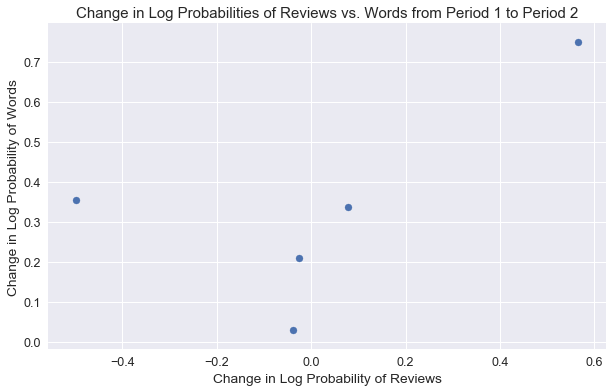

In [777]:
sns.set(font_scale=1.25)
plt.figure(figsize=(10,6))
plt.scatter(np.log(trends_df.period1_prob)-np.log(trends_df.period2_prob),
            np.log(trends_df.period1_wordprob)-np.log(trends_df.period2_wordprob))
plt.xlabel('Change in Log Probability of Reviews')
plt.ylabel('Change in Log Probability of Words')
plt.title('Change in Log Probabilities of Reviews vs. Words from Period 1 to Period 2')
plt.show()

The changes in log probabilities of concept reviews and concept words appear to be positively correlated, but the correlation is very weak.

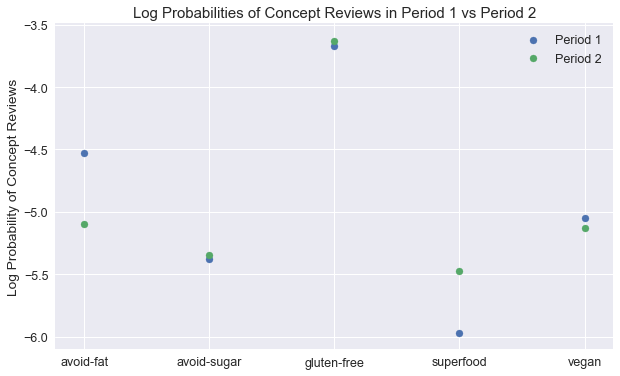

In [641]:
sns.set(font_scale=1.25)
plt.figure(figsize=(10,6))
plt.scatter(trends_df.index, np.log(trends_df.period1_prob), label='Period 1')
plt.scatter(trends_df.index, np.log(trends_df.period2_prob), label='Period 2')
plt.ylabel('Log Probability of Concept Reviews')
plt.legend()
plt.title('Log Probabilities of Concept Reviews in Period 1 vs Period 2')
plt.show()

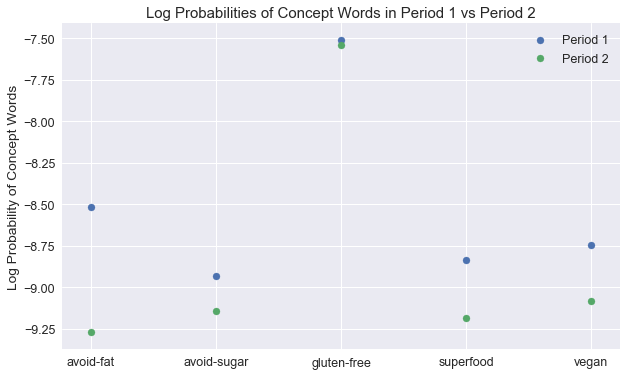

In [643]:
plt.figure(figsize=(10,6))
plt.scatter(trends_df.index, np.log(trends_df.period1_wordprob), label='Period 1')
plt.scatter(trends_df.index, np.log(trends_df.period2_wordprob), label='Period 2')
plt.ylabel('Log Probability of Concept Words')
plt.legend()
plt.title('Log Probabilities of Concept Words in Period 1 vs Period 2')
plt.show()

The changes in log probabilities of reviews about the food concepts reveal that avoid-fat is downward-trending and superfood is upward-trending. Avoid-sugar, gluten-free, and vegan remain stable.

The changes in log probabilities of word frequencies of the food concepts in reviews reveal that all concepts are downward-trending except for gluten-free, which is stable.

**Note**: The changes in log probabilities of reviews are more relevant for the assessment of trending concepts than the changes in log probabilities of word frequencies. Human behaviour/psychology is relevant here: as a food concept becomes more and more prevalent, people might be writing shorter reviews that don't repeat the same words as much. This is why the two scatterplots above do not look alike. There is a hidden variable concerning how reviews change as trends get underway: in terms of length (they might be getting shorter) as well as lexical patterns (there might be less repetition).

Now we would like to know if the upward trending food concepts are expanding their semantic range. For example, if GLUTEN-FREE foods are upward trending, does this mean that GLUTEN-FREE is expanding from its original stronghold in rice crackers into cake mixes, granola bars, Mexican foods, and even beverages? This is a tricky question to answer for such a high-dimensional representation. However, here is one approach.

**Step 1**: For each concept, find the centroid of the reviews about that concept.

In [652]:
# First we need to aggregate all reviews about each concept from period 1 and period 2.

df_gf = df_period1_gf.append(df_period2_gf)
df_avoidfat = df_period1_avoidfat.append(df_period2_avoidfat)
df_vegan = df_period1_vegan.append(df_period2_vegan)
df_superfood = df_period1_superfood.append(df_period2_superfood)
df_avoidsugar = df_period1_avoidsugar.append(df_period2_avoidsugar)

In [745]:
# We can use the avg_embedding function that we created above to compute the centroids.

gf_centroid = avg_embedding(df_gf.norm_text)
avoidfat_centroid = avg_embedding(df_avoidfat.norm_text)
vegan_centroid = avg_embedding(df_vegan.norm_text)
superfood_centroid = avg_embedding(df_superfood.norm_text)
avoidsugar_centroid = avg_embedding(df_avoidsugar.norm_text)

**Step 2**: Find the cosine distance of each review in Period 1 from the centroid. Find the standard error (SE) of the cosine distances. This is the standard deviation divided by $\sqrt{n}$, e.g., the square root of the sample size $n$.

In [731]:
# The above embedding function computed the mean embedding of all reviews about a product. 
# We need to write another function that computes the embedding of a single review.

def review_embedding(norm_text):
    
    wordlist = norm_text.split(' ')
    vocab_dict = Counter(wordlist)
    for word in list(vocab_dict):
        if word in stop_words.ENGLISH_STOP_WORDS or word=='':
            del vocab_dict[word]

    aggregate_vectors = []
    for word in list(vocab_dict):
        try:
            aggregate_vectors.extend(repeat(vectors[word], vocab_dict[word]))
        except:
#            print(word)
            continue
    
    return np.mean(aggregate_vectors, axis=0)

In [742]:
# Append a new column to the dataframe that is the embedding of the review text.

df_period1_gf['embedding'] = df_period1_gf.norm_text.map(lambda x: review_embedding(x)) 
df_period1_avoidfat['embedding'] = df_period1_avoidfat.norm_text.map(lambda x: review_embedding(x)) 
df_period1_vegan['embedding'] = df_period1_vegan.norm_text.map(lambda x: review_embedding(x)) 
df_period1_superfood['embedding'] = df_period1_superfood.norm_text.map(lambda x: review_embedding(x)) 
df_period1_avoidsugar['embedding'] = df_period1_avoidsugar.norm_text.map(lambda x: review_embedding(x))

In [753]:
# Append a new column that is the cosine distance between the review embeddings and the centroid.

df_period1_gf['cosine_dist'] = df_period1_gf.embedding.map(lambda x: (1-cosine(x, gf_centroid)))
df_period1_avoidfat['cosine_dist'] = df_period1_avoidfat.embedding.map(lambda x: (1-cosine(x, avoidfat_centroid)))
df_period1_vegan['cosine_dist'] = df_period1_vegan.embedding.map(lambda x: (1-cosine(x, vegan_centroid)))
df_period1_superfood['cosine_dist'] = df_period1_superfood.embedding.map(lambda x: (1-cosine(x, superfood_centroid)))
df_period1_avoidsugar['cosine_dist'] = df_period1_avoidsugar.embedding.map(lambda x: (1-cosine(x, avoidsugar_centroid)))

In [763]:
# Now we can compute the SE of the cosine distances.

period1_se = {}
period1_se['gluten-free'] = np.std(df_period1_gf['cosine_dist'])/np.sqrt(len(df_period1_gf))
period1_se['avoid-fat'] = np.std(df_period1_avoidfat['cosine_dist'])/np.sqrt(len(df_period1_avoidfat))
period1_se['vegan'] = np.std(df_period1_vegan['cosine_dist'])/np.sqrt(len(df_period1_vegan))
period1_se['superfood'] = np.std(df_period1_superfood['cosine_dist'])/np.sqrt(len(df_period1_superfood))
period1_se['avoid-sugar'] = np.std(df_period1_avoidsugar['cosine_dist'])/np.sqrt(len(df_period1_avoidsugar))
period1_se

{'avoid-fat': 0.0021744399491187565,
 'avoid-sugar': 0.003891593834020391,
 'gluten-free': 0.0013347685405204382,
 'superfood': 0.006516774003376299,
 'vegan': 0.0028775464075799354}

**Step 3**: Do the same thing for Period 2. Now we have two standard errors for each concept.

In [764]:
df_period2_gf['embedding'] = df_period2_gf.norm_text.map(lambda x: review_embedding(x)) 
df_period2_avoidfat['embedding'] = df_period2_avoidfat.norm_text.map(lambda x: review_embedding(x)) 
df_period2_vegan['embedding'] = df_period2_vegan.norm_text.map(lambda x: review_embedding(x)) 
df_period2_superfood['embedding'] = df_period2_superfood.norm_text.map(lambda x: review_embedding(x)) 
df_period2_avoidsugar['embedding'] = df_period2_avoidsugar.norm_text.map(lambda x: review_embedding(x))

In [765]:
df_period2_gf['cosine_dist'] = df_period2_gf.embedding.map(lambda x: (1-cosine(x, gf_centroid)))
df_period2_avoidfat['cosine_dist'] = df_period2_avoidfat.embedding.map(lambda x: (1-cosine(x, avoidfat_centroid)))
df_period2_vegan['cosine_dist'] = df_period2_vegan.embedding.map(lambda x: (1-cosine(x, vegan_centroid)))
df_period2_superfood['cosine_dist'] = df_period2_superfood.embedding.map(lambda x: (1-cosine(x, superfood_centroid)))
df_period2_avoidsugar['cosine_dist'] = df_period2_avoidsugar.embedding.map(lambda x: (1-cosine(x, avoidsugar_centroid)))

In [766]:
period2_se = {}
period2_se['gluten-free'] = np.std(df_period2_gf['cosine_dist'])/np.sqrt(len(df_period2_gf))
period2_se['avoid-fat'] = np.std(df_period2_avoidfat['cosine_dist'])/np.sqrt(len(df_period2_avoidfat))
period2_se['vegan'] = np.std(df_period2_vegan['cosine_dist'])/np.sqrt(len(df_period2_vegan))
period2_se['superfood'] = np.std(df_period2_superfood['cosine_dist'])/np.sqrt(len(df_period2_superfood))
period2_se['avoid-sugar'] = np.std(df_period2_avoidsugar['cosine_dist'])/np.sqrt(len(df_period2_avoidsugar))
period2_se

{'avoid-fat': 0.0009477984651880273,
 'avoid-sugar': 0.0011370379985279607,
 'gluten-free': 0.00039967078554246276,
 'superfood': 0.0013850079297126883,
 'vegan': 0.0008963393669585632}

The standard error is a measure of uncertainty in the estimate of the mean. Under the null hypothesis, both Period 1 and Period 2 are random samples from the same underlying distribution, but they are just different sizes of samples. So the underlying mean is the same, and the SE is expected to approach 0 as $\sqrt{n}$ approaches infinity. Thus, `SE_Period2` is expected to be: SE_Period1 * $\sqrt{n_1}$ /$\sqrt{n_2}$

**QUESTION 6**: Evaluate the extent to which the actual SE for each concept in Period 2 falls above, on, or below this prediction. Do upward tending concepts seem to be spreading out in the semantic space? Do downward trending concepts seem to be spreading out or shrinking during the same time?

In [ ]:
period2_pred_se = {}
period2_pred_se['gluten-free'] = period1_se['gluten-free'] * (np.sqrt(len(df_period1_gf))/np.sqrt(len(df_period2_gf)))
period2_pred_se['avoid-fat'] = period1_se['avoid-fat'] * (np.sqrt(len(df_period1_avoidfat))/np.sqrt(len(df_period2_avoidfat)))
period2_pred_se['vegan'] = period1_se['vegan'] * (np.sqrt(len(df_period1_vegan))/np.sqrt(len(df_period2_vegan)))
period2_pred_se['superfood'] = period1_se['superfood'] * (np.sqrt(len(df_period1_superfood))/np.sqrt(len(df_period2_superfood)))
period2_pred_se['avoid-sugar'] = period1_se['avoid-sugar'] * (np.sqrt(len(df_period1_avoidsugar))/np.sqrt(len(df_period2_avoidsugar)))

In [776]:
SE_df = pd.DataFrame.from_dict([period1_se, period2_se, period2_pred_se]).T
SE_df.columns = ['period1_SE', 'period2_SE', 'period2_pred_SE']
SE_df['SE_diff'] = SE_df.period2_pred_SE - SE_df.period2_SE
SE_df['SE_factor'] = SE_df.period2_SE / SE_df.period2_pred_SE
SE_df

,period1_SE,period2_SE,period2_pred_SE,SE_diff,SE_factor
avoid-fat,0.002174,0.000948,0.000876,-0.000072,1.081887
avoid-sugar,0.003892,0.001137,0.001166,0.000029,0.974744
gluten-free,0.001335,0.000400,0.000398,-0.000002,1.004850
superfood,0.006517,0.001385,0.001544,0.000159,0.897153
vegan,0.002878,0.000896,0.000908,0.000012,0.986663


As we discovered above, avoid-fat is downward-trending and superfood is upward-trending. Avoid-sugar, gluten-free, and vegan remain stable. The dataframe above illuminates that the SE for avoid-fat is 1.08 times greater than the prediction - so it appears to be spreading out in the semantic space. The SE for superfood, on the other hand, is only 0.90 that of the predicted value - so it appears to be shrinking in the semantic space. This represents the inverse of what we expected: upward-trending concepts should in theory be spreading out. Perhaps there are not too many superfood categories (it is inherently a narrower food concept than, e.g., avoid-fat due to its specificity), and yet the existing categories (namely chia and quinoa) are extremely popular.

We don't have a clear prediction for downward-trending concepts, however - if, e.g., avoid-fat was first used in the context of low-fat margarine and went out of style, it does not mean that it will remain restricted to the context of margarine or a small number of products. It can continue to be used to describe a wide variety of products, but the products themselves are less popular. This appears to be what is happening here.

The three stable concepts, gluten-free, superfood, and vegan, all have actual SEs that are very close to their predicted SEs: gluten-free especially (its actual value is virtually identical to its expected value). This confirms what we expected: the semantic range of stable concepts should neither increase nor decrease. 

### BONUS QUESTIONS

**Bonus Question 1**: Using word embeddings, you can obtain a quantitative measure of the distance between any pair of your review categories. However, such a measure only makes sense in relation to the amount of variability within each category. A large difference is not very important if the variability is so large that two categories have significant overlap. To
investigate this question, classify the COFFEE-REVIEWS, TEA-REVIEWS, CHOCOLATE-REVIEWS, and PETFOOD-REVIEWS into these four categories, and do a 10-fold cross validation (train on 90% of the data and test on 10%). You can do this by first computing the centroid for each product category, and then labelling the items in your held-out test set as instances of the closest centroid. Viz., take the vector of each review in the test set, find its cosine angle to each of the centroid vectors of the product categories, and label it as the closest product. Generate a confusion matrix for the results of the classification. Compute the F-score for each of the four categories averaged across all ten folds. Which categories have the most overlap?

**Bonus Question 2**: Much other work on semantic change in language trains different embeddings on the different stages of the language. This makes it possible to look at whether the embedding for a concept has moved and not just at the dispersion around the embedding. Using fastText or another relevant embedding method, train embeddings separately on the two periods in the dataset and evaluate the semantic changes.

**Bonus Question 3**: Because of our smallish text sample, we calculated word embeddings for words with as few as 20 examples. Assess the stability of the embedding estimates as a function of the word frequency. This will involve using a bootstrap analysis and retraining the embeddings many different times, with different documents left out.

**Bonus Question 4**: The relations amongst categories that are represented with high-dimensional vectors can be inspected visually using the t-Distributed Stochastic Neighbour Embedding (t-SNE) technique. This algorithm maps the dimensions onto a two-dimensional layout (in some cases it is a good idea to use PCA to reduce the dimensionality in advance). Try this out with all ten sets: Period 1 and Period 2 for each of the five concepts. Note that the result for any given concept will depend a great deal on what else is included in the same plot. Scikit-learn documentation for t-SNE and PCA are available here:
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html